# Spatial Segmentation and Key Drivers of Energy Consumption in England and Wales

*An analysis of consumer groups within the English and Welsh energy market and investigating socio-economic factors that influence the consumption patterns of different segments*

In [1697]:
# load relevant packages for analysis
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from shapely.geometry import Point
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

## 1.0 Introduction

The purpose of this paper is to segment UK consumers based on energy usage and investigate factors which are highly correlated to high and low energy consumption. 

Following economic sanctions placed on Russian oil in 2022, energy prices in Europe increased dramatically. This led to public discontent and *knee-jerk* relief payments provided by the public sector. While these payments provided short-term relief, investigating the nature of energy consumption in UK and the factors contributing to it can inform more targetted policy which could make the UK more reslient against price shocks and highlight circumstances that contribute to high and low energy consumption.

This paper uses clustering to segment energy consumers at a postcode level and investigates these clusters using multivariable regression.

## 2.0 Literature Review

Developing targetted policy involves market segmentation, segment analysis, implementation and ongoing monitoring (Soto et al., 2021). This paper, due to its analytical nature, will investigate the first two steps.

Segmentation plays a crucial role in developing targeted policies by identifying distinct groups within a population. This enables the creation of finely tuned interventions that are more likely to be effective and meet the needs of different segments (Soto et al., 2021).

Clustering has emerged as a powerful tool to delineate target populations more effectively for policy implementation. Balashankar et al. (2022) illustrate how clustering methods can help segment populations and identify distinct groups crucial for developing effective and targeted policies.

There are many clustering strategies. The most popular of which are Hierarchal, DBSCAN and K-means. DBSCAN and hierarchical clustering are able to effectively handle geographic data with varying shapes and reveal multi-level hierarchical relationships among data points.

From here, targetted policy development investigates segments to ascertain their characteritics. Multivariable regression is frequently used to evaluate the influence of socio-economic and environmental factors on distinct population segments. This approach controls for multiple variables simultaneously, pinpointing the impacts of each factor. By applying this method, researchers can provide precise insights essential for targeted policy formulation. This tailored approach improves the effectiveness and fairness of interventions, addressing the unique needs of different consumer groups (Balashankar et al., 2022).

There are three fields the ONS commonly reports alongside energy consumption. 1. **Central Heating Type**  is crucial for understanding energy consumption as it directly influences the efficiency and amount of energy required to heat homes, making it a pivotal variable for targeted energy-saving interventions. 2. **Income Level** and 3. **Dwelling Type** are similarly important; they reflect the economic capacity to invest in energy-efficient solutions and the physical characteristics of a home that affect energy needs, which can guide the formulation of policies tailored to specific economic and housing conditions.

With this in mind, this paper investgates 2 research questions.

            RQ1 | Can we use spatial clustering to effectively segment the UK population based on electricity and gas consumption behaviour?
            RQ2 | How do central heating type, income level and dwelling type correlate with the energy consumption patterns of different consumer segments?

## 3.0 Methodology

This study will leverage open data from the *Office of National Statistics (ONS)* and energy consumption data from the *UK Department for Energy Security and Net Zero (DESNZ)*. All datasets are from the 2022. 

The energy consumption data provided by DESNZ is at the postcode level, while other fields are provided by Local Authority District (LAD). To overcome this issue we proceed with clustering at a postcode level, then determine which LADs these clusters geographically sit within. If clusters sit within 2 or more LADs, we simply aggregate the energy consumption data from these clusters for each LAD using a weighted average based on the number of postcodes from the cluster falling within each LAD. This method ensures that our analysis accurately reflects the geographical distribution of consumption data while aligning it with the socio-economic data at the LAD level.

As outlined above, this analysis will be conducted in two parts. First, consumer segmentation will done using unsupervised clustering. This will done purely based on variables geography and electricity and gas consumption for several reasons (Rehmatulla et al., 2017). 

Starting with geography and energy consumption keeps the analysis clear and focused, allowing for an understanding of core consumption patterns without the distraction of socio-economic factors. Słupik et al. suggests that this method establishes baseline segments that reflect the interaction between geographic characteristics and energy usage, providing a reference for further analysis (2021). Adopting this phased approach enhances methodological rigour, enabling systematic integration of additional variables and ensuring the analysis remains robust as complexity increases.

Each cluster will be categorised into 4 segments based on quartiles, 1. High, 2. Medium-High, 3. Medium-Low and 4. Low Consumption.

Unsupervised clustering is selected over supervised methods because it effectively identifies natural groupings within the data without prior labeling, crucial for discovering inherent patterns in energy consumption that are not predefined. 

Next, we will determine what characteristics are highly correlated with *High*, *Medium-High*, *Medium-Low* and *Low* energy consumption. Since this analysis aims to inform domestic policy, we select variables that are commonly assciated with previous domestic energy relief, these are income, central heating type and dwelling type. This correlation analysis will be based heavily on multiple linear regression. Given the goal of informing targeted domestic energy policies, multiple linear regression allows for the simultaneous examination of how various predictors influence energy consumption across different segments(Forootan et al., 2022). 

This method not only quantifies the strength of these relationships but also adjusts for the interdependencies among variables, providing a comprehensive and statistically robust basis for policy recommendations (Dou et al., 2023).

## 4.0 Data Overview, Processing & Exploration

This section reads in and processes the data for RQ1 and RQ2. Before moving into our analysis we provide an overview of the fields, explore the shape and distribution of our data and check for outliers and incosistencies which could lead to issues in this study. This will all be conducted in the following section after the cleaning phase of each dataset. 

The energy consumption from the DESNZ is provided at outcode level without geometry. The geopy library automatically finds and builds a geometry column based on outcode. DESNEZ provide mean, median and total electricity and gas consumption data by Kilowatt-hour (kWh). Below we drop both the *Mean* and *Total* consumption column and use *Median* annual electrity and gas consumption as it is least impacted by outliers. For this reason we do not normlise by population.

The [geopy](https://geopy.readthedocs.io/en/stable/) library can only assign one postcode per second and is computationally intensive. As a result, we only run this on the gas consumption data and join electricity data later.

As highlighted, the following is a computational intense process and was run when this analysis was originally conducted. The new CSV file is read in below the following four code chunks.

### 4.1 Read in Energy Consumption Data, Process and add Geometry

In [723]:
# read in desnez data
gas_df = pd.read_csv('data/gas_consumption.csv')
elec_df = pd.read_csv('data/electricity_consumption.csv')
outpop_df = pd.read_csv('data/outcode_population.csv') # pop. by outcode to normalise

In [725]:
# init geolocator
geolocator = Nominatim(user_agent="geoapiExercises")

# function to get lat / long
def get_lat_lon(outcode):
    try:
        location = geolocator.geocode(f"{outcode}, United Kingdom")
        return (location.latitude, location.longitude)
    except:
        return (None, None)

# avoid hitting rate limits
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# apply to outcode column
gas_df['Latitude_Longitude'] = gas_df['outcode'].apply(lambda x: get_lat_lon(x))

gas_df.to_csv('data/gas_df.csv', index=False)

In [2756]:
gas_df = pd.read_csv('data/gas_df.csv')

In [2757]:
gas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2410 entries, 0 to 2409
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   outcode              2410 non-null   object 
 1   gas_total_cons_kwh   2410 non-null   float64
 2   gas_mean_cons_kwh    2410 non-null   float64
 3   gas_median_cons_kwh  2410 non-null   float64
 4   Latitude_Longitude   2410 non-null   object 
dtypes: float64(3), object(2)
memory usage: 94.3+ KB


In [2758]:
# convert string coordinates to a point object
def parse_coordinates(coord_str):
    if coord_str == "None, None":
        return None
    try:
        lat, lon = coord_str.strip('()').split(',')
        return Point(float(lon.strip()), float(lat.strip()))
    except (ValueError, TypeError):
        return None

# Apply to 'Latitude_Longitude'
gas_df['geometry'] = gas_df['Latitude_Longitude'].apply(parse_coordinates)

# Remove 'None' rows
gas_df = gas_df[gas_df['geometry'].notna()]

# DataFrame to GeoDataFrame
gas_gdf = gpd.GeoDataFrame(gas_df, geometry='geometry')

# Set WGS 84 CRS
gas_gdf.set_crs(epsg=4326, inplace=True)

# Join electricity consumption data by outcode
energycon_gdf = pd.merge(gas_gdf, elec_df, on='outcode', how='inner')

# Drop total & mean consumption columns
columns_to_drop = ['gas_total_cons_kwh', 'gas_mean_cons_kwh', 'elec_total_cons_kwh', 'elec_mean_cons_kwh', 'Latitude_Longitude']
energycon_gdf = energycon_gdf.drop(columns=columns_to_drop)

In [2759]:
# normalise our energy consumption data by outcode population 
# perform inner join
energycon_gdf = pd.merge(
    energycon_gdf,
    outpop_df[['Postcode Districts', 'Count']],
    left_on='outcode',
    right_on='Postcode Districts',
    how='inner'
)

# normalise x population count
energycon_gdf['n_gas_median_cons_kwh'] = energycon_gdf['gas_median_cons_kwh'] / energycon_gdf['Count']
energycon_gdf['n_elec_median_cons_kwh'] = energycon_gdf['elec_median_cons_kwh'] / energycon_gdf['Count']

# drop 'Postcode Districts'
energycon_gdf.drop(columns=['Postcode Districts'], inplace=True)

# calc mean and standard deviation
mean_values = energycon_gdf[['n_gas_median_cons_kwh', 'n_elec_median_cons_kwh']].mean()
std_dev = energycon_gdf[['n_gas_median_cons_kwh', 'n_elec_median_cons_kwh']].std()

# detect and remove outliers more than 2 StD. from the mean
is_outlier = ((energycon_gdf[['n_gas_median_cons_kwh', 'n_elec_median_cons_kwh']] < (mean_values - 2 * std_dev)) |
              (energycon_gdf[['n_gas_median_cons_kwh', 'n_elec_median_cons_kwh']] > (mean_values + 2 * std_dev))).any(axis=1)
energycon_gdf = energycon_gdf[~is_outlier]

# save
energycon_gdf.to_file('energycon.gpkg', driver='GPKG')

In [2760]:
# read in processed 'energy consumption data' & check
energycon_gdf = gpd.read_file('energycon.gpkg')
energycon_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1429 entries, 0 to 1428
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   outcode                 1429 non-null   object  
 1   gas_median_cons_kwh     1429 non-null   float64 
 2   elec_median_cons_kwh    1429 non-null   float64 
 3   Count                   1429 non-null   int64   
 4   n_gas_median_cons_kwh   1429 non-null   float64 
 5   n_elec_median_cons_kwh  1429 non-null   float64 
 6   geometry                1429 non-null   geometry
dtypes: float64(4), geometry(1), int64(1), object(1)
memory usage: 78.3+ KB


In [2761]:
numeric_cols = energycon_gdf.select_dtypes(include=[np.number])

# descriptive stats
basic_stats = numeric_cols.describe()

# count of non-null entries
nonnull_counts = energycon_gdf.count()

# data types
data_types = energycon_gdf.dtypes

# quantiles
quantiles = numeric_cols.quantile([0.25, 0.5, 0.75])

# correlation matrix
correlation_matrix = numeric_cols.corr()

# display
print("Descriptive Statistics:\n", basic_stats)
print("\nCount of Non-Null Entries:\n", nonnull_counts)
print("\nData Types:\n", data_types)
print("\nQuantiles:\n", quantiles)
print("\nCorrelation Matrix:\n", correlation_matrix)

Descriptive Statistics:
        gas_median_cons_kwh  elec_median_cons_kwh          Count  \
count          1429.000000           1429.000000    1429.000000   
mean          10095.291839           2611.974050   27664.167950   
std            1998.934236            352.451779   17787.980163   
min            3728.318537           1577.100000      55.000000   
25%            8926.833145           2392.400000   14852.000000   
50%            9815.550000           2542.000000   25310.000000   
75%           10889.086886           2772.200000   36906.000000   
max           28575.457630           5444.500000  170304.000000   

       n_gas_median_cons_kwh  n_elec_median_cons_kwh  
count            1429.000000             1429.000000  
mean                1.340411                0.339435  
std                 8.360627                2.049145  
min                 0.059852                0.014346  
25%                 0.256299                0.066603  
50%                 0.386284             

#### Given the following summary statistics we can infer the following conclusions about our data:
- **Consumption Variability:** The dataset from 1,429 outcodes shows a median gas consumption range of 3,728 to 28,575 kWh, with electricity consumption being less variable, ranging from 1,577 to 5,444 kWh. Median gas consumption typically around 9,815 kWh reflects substantial regional differences.
- **Correlation and Efficiency:** There's a moderate correlation (about 0.46) between gas and electricity consumption, suggesting that higher gas usage often aligns with higher electricity usage. Normalised consumption values reveal efficiencies of about 1.34 kWh for gas and 0.34 kWh for electricity per unit count, with some regions showing exceptionally high usage.
- **Statistical Overview:** The dataset exhibits a broad count range from 55 to 170,304, suggesting diverse outcode sizes. All key columns are fully populated, ensuring comprehensive data analysis. The strong correlation (0.977) between normalised gas and electricity values underscores consistent regional energy usage patterns.

Below, we read and process the socio-economic data for the clustering and segmentation analysis. There are five fields taken from four datasets recorded by LAD. The population, dwelling type, central heating type and income data all comes from the ONS. This data is merged with LAD polygon data, also provided by the ONS. 

The socio-economic data is provided as raw counts, thus, we conduct per capita normalisation to ensure our analysis is accurate. During the normalisation process we deal with NaN and 0 values.

### 4.2 Read in Socio-Economic Data, Process and add Geometry column

In [2764]:
# read in ONS socioeconomic & LAD geometry data
income = pd.read_csv('data/annual_income.csv') # annual income
heat_type = pd.read_csv('data/heating_type.csv') # central heating type
dw_type = pd.read_csv('data/accomodation_type.csv') # dwelling type
lad = gpd.read_file("data/Local_Authority_Districts/LAD_MAY_2022_UK_BFE_V3.shp") # lad polygon data
pop = pd.read_excel("data/population.xlsx") # pop

In [2765]:
# process and clean income data
median_income = income.groupby('Local authority code')['Total annual income (£)'].median().reset_index()

# rename 'med average annual income' & print
median_income.rename(columns={'Total annual income (£)': 'Med average annual income (£)'}, inplace=True)
median_income.rename(columns={'Local authority code': 'Lower tier local authorities Code'}, inplace=True)
median_income.head(2)

,Lower tier local authorities Code,Med average annual income (£)
0,E06000001,31050.0
1,E06000002,35500.0


In [2766]:
# process heating & dwelling type data
# pivot heating type
heatpivot_df = heat_type.pivot(
    index='Lower tier local authorities Code',
    columns='Type of central heating in household (5 categories)',
    values='Observation'
)

# 'LAD Code' as index
heatpivot_df.reset_index(inplace=True)

# pivot 'dw type'
dwpivot_df = dw_type.pivot(index='Lower tier local authorities Code', 
                         columns='Accommodation type (5 categories)', 
                         values='Observation')

# 'LAD Code' as index
dwpivot_df.reset_index(inplace=True)

In [2767]:
# merge 'dwpivot_df' and 'heatpivot_df' on 'Lower tier local authorities Code'
merged_df = pd.merge(dwpivot_df, heatpivot_df, on='Lower tier local authorities Code', how='outer')

# merge with 'income' on 'Lower tier local authorities Code'
socec_df = pd.merge(merged_df, median_income, on='Lower tier local authorities Code', how='outer')

# display
socec_df.head(2)

,Lower tier local authorities Code,A caravan or other mobile or temporary structure,"Flat, maisonette or apartment",Whole house or bungalow: Detached,Whole house or bungalow: Semi-detached,Whole house or bungalow: Terraced,Does not apply,Does not have central heating,Has one type of central heating,Two or more types of central heating (including renewable energy),Two or more types of central heating (not including renewable energy),Med average annual income (£)
0,E06000001,115.0,4725.0,8086.0,14537.0,13469.0,0.0,342.0,36686.0,180.0,3722.0,31050.0
1,E06000002,51.0,7569.0,10389.0,25485.0,16768.0,0.0,752.0,53648.0,178.0,5684.0,35500.0


In [2768]:
# merge 'LAD' and 'socec_df' geographic data
lad_filtered = lad[['LAD22CD', 'geometry']]

# keep all 'socec_df' columns and only 'geometry' from 'lad'
socec_df = pd.merge(socec_df, lad_filtered, how='left', left_on='Lower tier local authorities Code', right_on='LAD22CD')

# drop 'LAD22CD' & display
socec_df.drop(columns=['LAD22CD'], inplace=True)

In [2769]:
# final cleaning
# drop
socec_df.drop(columns=['Does not apply'], inplace=True)

# rename index as 'LAD'
socec_df.rename(columns={'Lower tier local authorities Code': 'LAD'}, inplace=True)

# geometry as last column
geometry = socec_df.pop('geometry')
socec_df['geometry'] = geometry

# rename
column_rename_map = {
    'A caravan or other mobile or temporary structure': 'dwelling_type: mobile',
    'Flat, maisonette or apartment': 'dwelling_type: flat',
    'Whole house or bungalow: Detached': 'dwelling_type: detached house',
    'Whole house or bungalow: Semi-detached': 'dwelling_type: semi-detached',
    'Whole house or bungalow: Terraced': 'dwelling_type: terraced',
    'Does not have central heating': 'no central heating',
    'Has one type of central heating': '1 central heating',
    'Two or more types of central heating (including renewable energy)': '2+ central heating (renewable)',
    'Two or more types of central heating (not including renewable energy)': '2+ central heating (non-renewable)',
    'Med average annual income (£)': 'mean annual income'
}
socec_df.rename(columns=column_rename_map, inplace=True)

# print
socec_df.head(2)

,LAD,dwelling_type: mobile,dwelling_type: flat,dwelling_type: detached house,dwelling_type: semi-detached,dwelling_type: terraced,no central heating,1 central heating,2+ central heating (renewable),2+ central heating (non-renewable),mean annual income,geometry
0,E06000001,115.0,4725.0,8086.0,14537.0,13469.0,342.0,36686.0,180.0,3722.0,31050.0,"POLYGON ((447213.900 537036.104, 447228.798 53..."
1,E06000002,51.0,7569.0,10389.0,25485.0,16768.0,752.0,53648.0,178.0,5684.0,35500.0,"POLYGON ((448489.897 522071.798, 448592.597 52..."


In [2770]:
# normalise these values by the population of each LAD 
# start by adding population to df:
# left join data using 'socec_df' as master
pop_filtered = pop[['Code', 'All ages']]
socec_df = pd.merge(socec_df, pop_filtered, how='left', left_on='LAD', right_on='Code')

# rename 'All ages' column to 'population' and drop redundant 'Code' column
socec_df.rename(columns={'All ages': 'population'}, inplace=True)
socec_df.drop(columns=['Code'], inplace=True)

In [2771]:
# normalise all the necessary fields
# columns to normalise
columns_to_normalise = [
    'dwelling_type: mobile', 'dwelling_type: flat', 'dwelling_type: detached house',
    'dwelling_type: semi-detached', 'dwelling_type: terraced',
    'no central heating', '1 central heating',
    '2+ central heating (renewable)', '2+ central heating (non-renewable)'
]

# remove rows where pop is NaN / 0
cleaned_df = socec_df[socec_df['population'].notna() & (socec_df['population'] > 0)]

# new df for normalised data
nsocec_df = cleaned_df[['LAD', 'geometry', 'mean annual income']].copy()

# normalise each column by population & display
for column in columns_to_normalise:
    nsocec_df[column] = cleaned_df[column] / cleaned_df['population']
nsocec_df.head(2)

,LAD,geometry,mean annual income,dwelling_type: mobile,dwelling_type: flat,dwelling_type: detached house,dwelling_type: semi-detached,dwelling_type: terraced,no central heating,1 central heating,2+ central heating (renewable),2+ central heating (non-renewable)
0,E06000001,"POLYGON ((447213.900 537036.104, 447228.798 53...",31050.0,0.001225,0.050340,0.086149,0.154878,0.143499,0.003644,0.390855,0.001918,0.039654
1,E06000002,"POLYGON ((448489.897 522071.798, 448592.597 52...",35500.0,0.000344,0.051044,0.070061,0.171865,0.113080,0.005071,0.361790,0.001200,0.038332


In [2772]:
# convert to gdf using epsg:4326
nsocec_gdf = gpd.GeoDataFrame(nsocec_df, geometry='geometry')
nsocec_gdf.set_crs("epsg:4326", inplace=True, allow_override=True)
nsocec_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 314 entries, 0 to 330
Data columns (total 12 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   LAD                                 314 non-null    object  
 1   geometry                            314 non-null    geometry
 2   mean annual income                  301 non-null    float64 
 3   dwelling_type: mobile               314 non-null    float64 
 4   dwelling_type: flat                 314 non-null    float64 
 5   dwelling_type: detached house       314 non-null    float64 
 6   dwelling_type: semi-detached        314 non-null    float64 
 7   dwelling_type: terraced             314 non-null    float64 
 8   no central heating                  314 non-null    float64 
 9   1 central heating                   314 non-null    float64 
 10  2+ central heating (renewable)      314 non-null    float64 
 11  2+ central heating (non-renew

The socioeconomic data is merged and formatted. Below we produce the summary statistics for each field.

In [2774]:
# summary statistics for numeric fields
numeric_stats = nsocec_gdf.describe()

# statistics for 'geometry'
if 'geometry' in nsocec_gdf.columns:
    geometry_types = nsocec_gdf['geometry'].geom_type.value_counts()

# numeric statistics
print("Numeric Fields Summary Statistics:\n", numeric_stats)

# print the geometry statistics
if 'geometry' in nsocec_gdf.columns:
    print("\nGeometry Types:\n", geometry_types)

Numeric Fields Summary Statistics:
        mean annual income  dwelling_type: mobile  dwelling_type: flat  \
count          301.000000             314.000000           314.000000   
mean         46630.232558               0.002067             0.082017   
std           9870.109740               0.002098             0.065401   
min          31050.000000               0.000000             0.017910   
25%          39000.000000               0.000503             0.044090   
50%          44600.000000               0.001333             0.063788   
75%          53350.000000               0.002957             0.094242   
max         101800.000000               0.013217             0.443809   

       dwelling_type: detached house  dwelling_type: semi-detached  \
count                     314.000000                    314.000000   
mean                        0.108347                      0.130504   
std                         0.055624                      0.037655   
min                       

The average mean annual income across the 301 entries is approximately £46,630, but the range is quite broad, with a maximum income reported as £101,800. The normalised dwelling data reveals a predominance of flats and semi-detached houses, with relatively minor variations in central heating systems, suggesting a general uniformity in dwelling types and heating across the sampled regions.

The presence of missing data in 'mean annual income' alongside its lack of normalisation may skew comparative analyses, especially when compared to other per capita normalised metrics. The mix of Polygon and MultiPolygon geometries in the dataset necessitates careful handling to ensure accuracy in spatial operations and consistency in geographic analyses.

In [2776]:
# address missing data in 'mean annual income'
print(f"Missing data in 'mean annual income' before cleanup: {nsocec_gdf['mean annual income'].isna().sum()}")
nsocec_gdf['mean annual income'].fillna(nsocec_gdf['mean annual income'].median(), inplace=True)
print(f"After imputing missing values with median: {nsocec_gdf['mean annual income'].isna().sum()}")

# ensure geometry consistency
nsocec_gdf['geometry'] = nsocec_gdf['geometry'].apply(lambda x: x if x.is_valid else x.buffer(0))
nsocec_gdf = nsocec_gdf.explode('geometry', index_parts=True)

# correct data type inconsistencies
nsocec_gdf['mean annual income'] = pd.to_numeric(nsocec_gdf['mean annual income'], errors='coerce')

# status report
print("\nData Types in DataFrame:")
nsocec_gdf.head()

Missing data in 'mean annual income' before cleanup: 13
After imputing missing values with median: 0

Data Types in DataFrame:


,,LAD,mean annual income,dwelling_type: mobile,dwelling_type: flat,dwelling_type: detached house,dwelling_type: semi-detached,dwelling_type: terraced,no central heating,1 central heating,2+ central heating (renewable),2+ central heating (non-renewable),geometry
0,0,E06000001,31050.0,0.001225,0.050340,0.086149,0.154878,0.143499,0.003644,0.390855,0.001918,0.039654,"POLYGON ((447213.89950 537036.10450, 447228.79..."
1,0,E06000002,35500.0,0.000344,0.051044,0.070061,0.171865,0.113080,0.005071,0.361790,0.001200,0.038332,"POLYGON ((448489.89690 522071.79790, 448592.59..."
2,0,E06000003,34000.0,0.000612,0.040066,0.090753,0.203696,0.114204,0.004148,0.403251,0.002260,0.039679,"POLYGON ((455525.93100 528406.65420, 455724.63..."
3,0,E06000004,35850.0,0.000395,0.038392,0.111064,0.177500,0.091506,0.003526,0.376619,0.001975,0.036736,"POLYGON ((444157.00190 527956.30350, 444165.89..."
4,0,E06000005,36100.0,0.000713,0.058683,0.085239,0.174917,0.127315,0.004257,0.404863,0.002074,0.035681,"POLYGON ((423496.60200 524724.29870, 423497.20..."


In [2777]:
nsocec_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 446 entries, (0, 0) to (330, 0)
Data columns (total 12 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   LAD                                 446 non-null    object  
 1   mean annual income                  446 non-null    float64 
 2   dwelling_type: mobile               446 non-null    float64 
 3   dwelling_type: flat                 446 non-null    float64 
 4   dwelling_type: detached house       446 non-null    float64 
 5   dwelling_type: semi-detached        446 non-null    float64 
 6   dwelling_type: terraced             446 non-null    float64 
 7   no central heating                  446 non-null    float64 
 8   1 central heating                   446 non-null    float64 
 9   2+ central heating (renewable)      446 non-null    float64 
 10  2+ central heating (non-renewable)  446 non-null    float64 
 11  geometry      

## 5.0 Analysis

After cleaning and conducting an inner join on the energy consumption data, there are 1429 data points remaining. We now proceed with the analysis. First, this entails segmentation and secondly a socioeconomic analysis of those consumers segments.

### 5.1 Segmentation of UK Energy Consumers: Unsupervised Clustering

Below, we leverage unsupervised spatial clustering to group consumers based on energy consumption and geography. These groups will then be categorised into four segments we will use in the second part of our analysis. These segments are:
- High: Top 25% of consumption
- Medium-High: 50-75% of consumption
- Medium-Low: 25-50% of consumption
- Low: Bottom 25% of consumption

In our study of UK energy consumption, we applied the K-Means clustering algorithm to segment consumers based on usage and location. The optimal number of clusters was determined using the Elbow Method, which identifies the point where the increase in clusters ceases to significantly reduce the within-cluster sum of squares. This approach helps in choosing an appropriate cluster count that maximises both cluster compactness and separation.

The effectiveness of the clusters was evaluated using the Silhouette Score, a measure of how well-separated the clusters are relative to their proximity. High Silhouette Scores indicate well-defined clusters, supporting the robustness of our clustering approach, which is crucial for informed energy policy development.

In [2780]:
# read consumption data & view
gdf = gpd.read_file('energycon.gpkg')
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1429 entries, 0 to 1428
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   outcode                 1429 non-null   object  
 1   gas_median_cons_kwh     1429 non-null   float64 
 2   elec_median_cons_kwh    1429 non-null   float64 
 3   Count                   1429 non-null   int64   
 4   n_gas_median_cons_kwh   1429 non-null   float64 
 5   n_elec_median_cons_kwh  1429 non-null   float64 
 6   geometry                1429 non-null   geometry
dtypes: float64(4), geometry(1), int64(1), object(1)
memory usage: 78.3+ KB


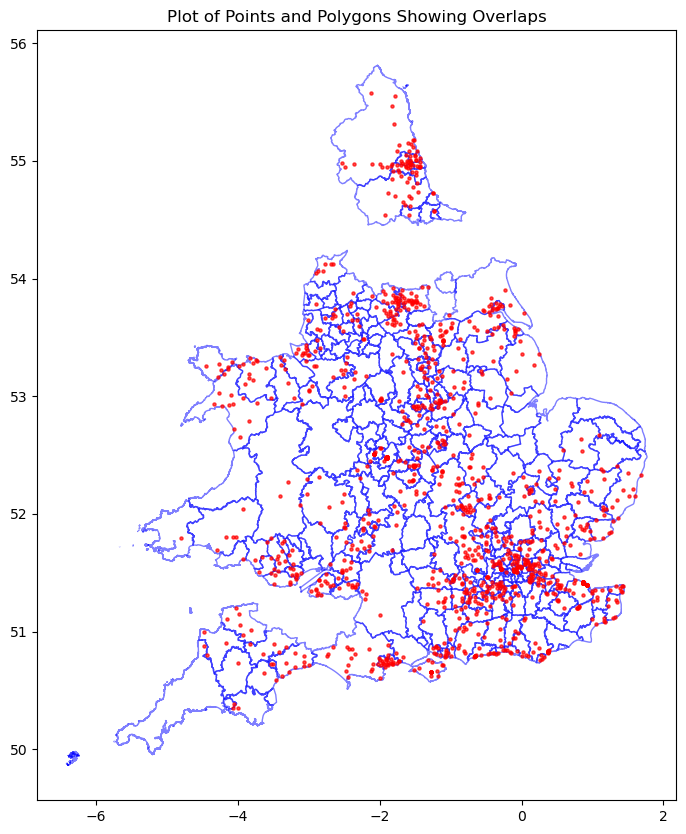

In [2781]:
# here we conduct a spatial join and remove all energy consumption point data if it does not align with a LAD with socec data
# convert CRS to EPSG:4326
nsocec_gdf = nsocec_gdf.set_crs("EPSG:27700", allow_override=True)
nsocec_gdf = nsocec_gdf.to_crs("EPSG:4326")

# inner spatial join to keep only overlapping geometries
joined_df = gpd.sjoin(gdf, nsocec_gdf, how='inner', predicate='intersects')

# drop 'index_right0' & 'index_right1'
joined_df.drop(columns=['index_right0', 'index_right1'], inplace=True)

# head
joined_df.head()

# overlap
points_filtered = joined_df[['geometry']].copy()
fig, ax = plt.subplots(figsize=(10, 10))
nsocec_gdf.plot(ax=ax, color='none', edgecolor='blue', alpha=0.5)  # polygons
points_filtered.plot(ax=ax, color='red', markersize=5, alpha=0.7)  # points (only from join)
plt.title('Plot of Points and Polygons Showing Overlaps')
plt.show()

In [2782]:
joined_df.info()
# the this joined eliminates about 160 points

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1264 entries, 0 to 1427
Data columns (total 18 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   outcode                             1264 non-null   object  
 1   gas_median_cons_kwh                 1264 non-null   float64 
 2   elec_median_cons_kwh                1264 non-null   float64 
 3   Count                               1264 non-null   int64   
 4   n_gas_median_cons_kwh               1264 non-null   float64 
 5   n_elec_median_cons_kwh              1264 non-null   float64 
 6   geometry                            1264 non-null   geometry
 7   LAD                                 1264 non-null   object  
 8   mean annual income                  1264 non-null   float64 
 9   dwelling_type: mobile               1264 non-null   float64 
 10  dwelling_type: flat                 1264 non-null   float64 
 11  dwelling_type: detached hou

In [2783]:
#init. values for the spatial clustering
joined_df['x'] = joined_df.geometry.x
joined_df['y'] = joined_df.geometry.y

# prep data for clustering
X = joined_df[['n_gas_median_cons_kwh', 'n_elec_median_cons_kwh', 'x', 'y']]

# scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

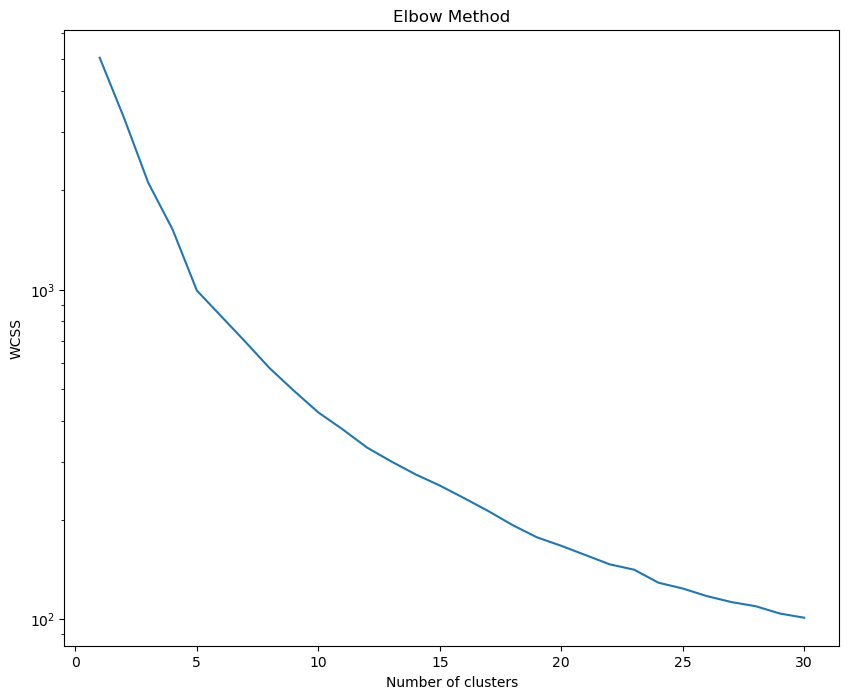

In [2784]:
# elbow analysis
wcss = []
for i in range(1, 31):  # 1 to 30
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=20, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# plot WCSS values
plt.figure(figsize=(10, 8))
plt.plot(range(1, 31), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.yscale('log')
plt.show()

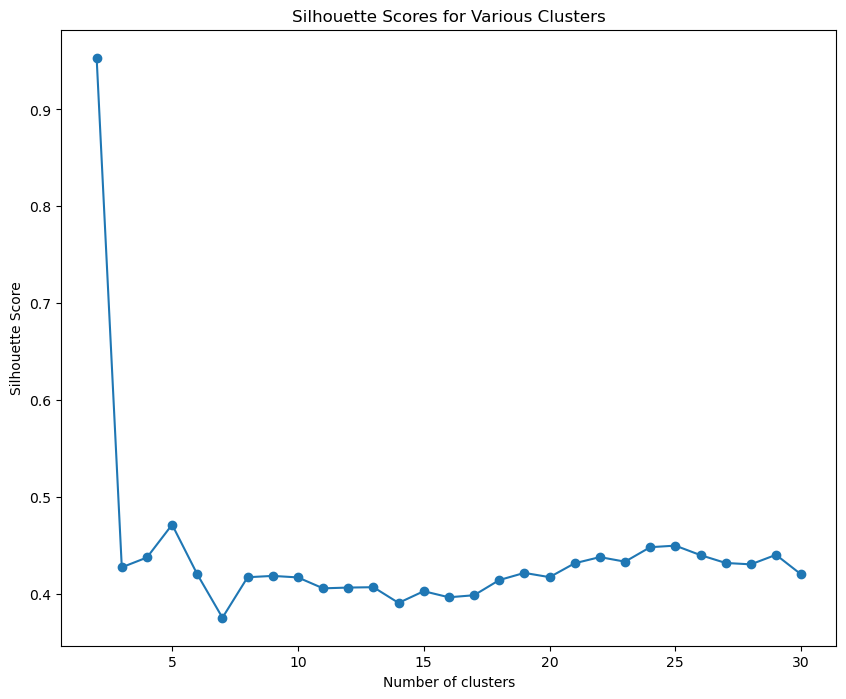

In [2785]:
# init and create loop
silhouette_scores = []
for i in range(2, 31):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=20, random_state=0)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

# plot silhouette scores
plt.figure(figsize=(10, 8))
plt.plot(range(2, 31), silhouette_scores, marker='o')
plt.title('Silhouette Scores for Various Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

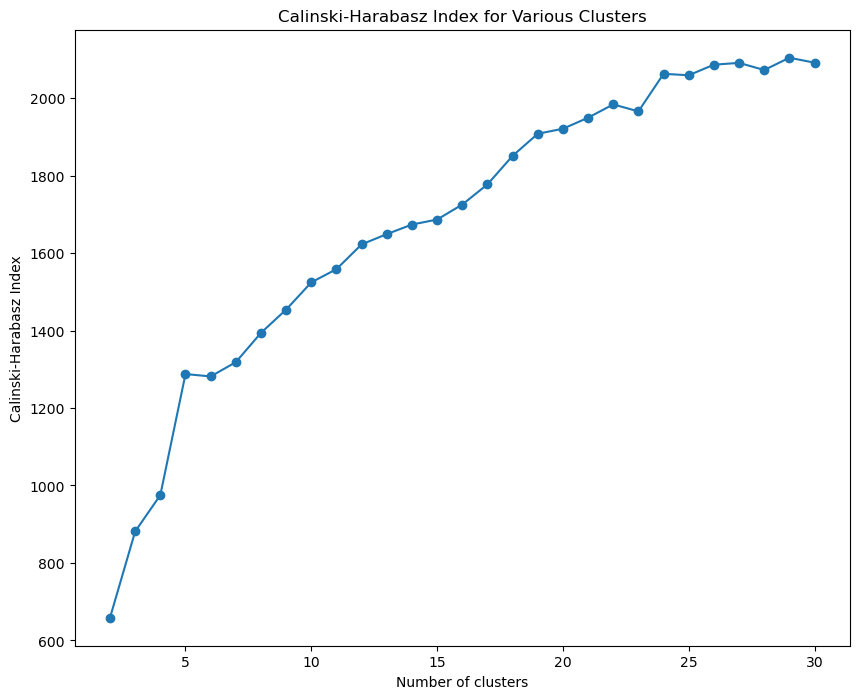

In [2786]:
# Calinski-Harabasz Index
calinski_harabasz_scores = []
for i in range(2, 31):  # Cannot compute with only one cluster
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=20, random_state=0)
    labels = kmeans.fit_predict(X_scaled)
    score = calinski_harabasz_score(X_scaled, labels)
    calinski_harabasz_scores.append(score)

# plot CH index
plt.figure(figsize=(10, 8))
plt.plot(range(2, 31), calinski_harabasz_scores, marker='o')
plt.title('Calinski-Harabasz Index for Various Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz Index')
plt.show()

#### 5.1.1 Number of Clusters
The Elbow Method suggests a more gradual WCSS decrease from 6 clusters, while the Silhouette Score plateaus after 7, indicating stable cluster definition. The Calinski-Harabasz Index increases with more clusters and shows no clear plateau. Between 6 - 7 the gradient becomes more stable. Combining these insights, starting with 7 clusters would balance distinctness and model complexity, aligning with the goal of identifying meaningful UK energy consumption segments.

/Users/nikhildesai/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


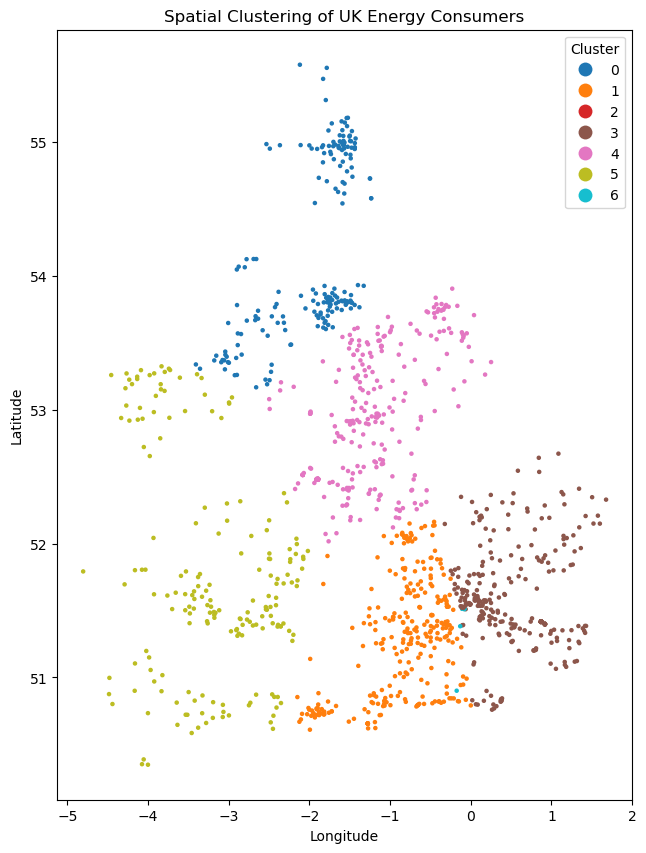

In [2788]:
# 7 clusters
optimal_clusters = 7
kmeans = KMeans(n_clusters=optimal_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(X_scaled)

# cluster labels
joined_df['cluster'] = cluster_labels

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
joined_df.plot(column='cluster', ax=ax, categorical=True, markersize=5, legend=True, legend_kwds={'title': "Cluster"})

plt.title('Spatial Clustering of UK Energy Consumers')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

#### 5.1.2 Segment Clusters by Quartile
K-means has grouped UK energy consumers into 10 clusters. Below we segment clusters into 1 of 4 consumption types outlined above.

In [2790]:
# calc total energy cons.
joined_df['total_energy'] = joined_df['n_gas_median_cons_kwh'] + joined_df['n_elec_median_cons_kwh']

# calc median total energy consumption for each cluster
cluster_median = joined_df.groupby('cluster')['total_energy'].median().sort_values()

# quartile cutoffs for total energy consumption among clusters
quantiles = cluster_median.quantile([0.25, 0.5, 0.75])

# to determine category based on quartiles
def consumption_category(value):
    if value <= quantiles.iloc[0]:
        return 'Low'
    elif value <= quantiles.iloc[1]:
        return 'Medium-Low'
    elif value <= quantiles.iloc[2]:
        return 'Medium-High'
    else:
        return 'High'

# map clusters to category
cluster_to_category = cluster_median.map(consumption_category).to_dict()
joined_df['consumption_section'] = joined_df['cluster'].map(cluster_to_category)

joined_df

,outcode,gas_median_cons_kwh,elec_median_cons_kwh,Count,n_gas_median_cons_kwh,n_elec_median_cons_kwh,geometry,LAD,mean annual income,dwelling_type: mobile,...,dwelling_type: terraced,no central heating,1 central heating,2+ central heating (renewable),2+ central heating (non-renewable),x,y,cluster,total_energy,consumption_section
0,AL1,11212.445815,2704.2,39038,0.287219,0.069271,POINT (-1.23428 54.57754),E06000002,35500.0,0.000344,...,0.113080,0.005071,0.361790,0.001200,0.038332,-1.234282,54.577542,0,0.356490,Medium-Low
2,AL2,12388.751514,2917.6,24211,0.511699,0.120507,POINT (-1.23429 54.57725),E06000002,35500.0,0.000344,...,0.113080,0.005071,0.361790,0.001200,0.038332,-1.234295,54.577255,0,0.632206,Medium-Low
1,AL10,9859.944538,2522.9,38933,0.253254,0.064801,POINT (-0.22457 51.77064),E07000241,44600.0,0.001065,...,0.123231,0.003644,0.347833,0.002088,0.030829,-0.224566,51.770635,3,0.318055,Low
7,AL7,8830.802190,2439.4,36930,0.239123,0.066055,POINT (-0.19593 51.80467),E07000241,44600.0,0.001065,...,0.123231,0.003644,0.347833,0.002088,0.030829,-0.195926,51.804673,3,0.305177,Low
8,AL8,11826.127001,2851.3,13596,0.869824,0.209716,POINT (-0.24703 51.79689),E07000241,44600.0,0.001065,...,0.123231,0.003644,0.347833,0.002088,0.030829,-0.247026,51.796893,3,1.079540,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1423,SA14,8921.626667,2535.6,35356,0.252337,0.071716,POINT (-4.07525 51.80427),W06000010,37700.0,0.002401,...,0.081177,0.004754,0.383313,0.003368,0.040885,-4.075254,51.804268,5,0.324053,Medium-High
1424,SA15,8822.299817,2280.1,37743,0.233747,0.060411,POINT (-4.16227 51.80093),W06000010,37700.0,0.002401,...,0.081177,0.004754,0.383313,0.003368,0.040885,-4.162265,51.800932,5,0.294158,Medium-High
1425,SA16,8842.560518,2241.8,8291,1.066525,0.270390,POINT (-4.29071 51.69504),W06000010,37700.0,0.002401,...,0.081177,0.004754,0.383313,0.003368,0.040885,-4.290709,51.695043,5,1.336915,Medium-High
1426,SA18,10453.039155,2522.4,30428,0.343534,0.082897,POINT (-4.03219 51.80476),W06000010,37700.0,0.002401,...,0.081177,0.004754,0.383313,0.003368,0.040885,-4.032185,51.804761,5,0.426431,Medium-High


### 5.3 Factors Contributing to Segment Energy Consumption: Multiple Linear Regression Analysis
Energy consumers and now clustered and segmented. Below, each segment is assessed against socio-economic data to understand which socioeconomic factors are correlated with each segment. There are three steps conducted in this analysis:

- **Data Preparation:** The dataset is prepared by categorising energy consumption into four segments ("Low," "Medium-Low," "Medium-High," "High") and mapping these to numerical codes for regression analysis. Socioeconomic factors are identified and organised for inclusion as independent variables.
- **Regression Analysis per Cluster:** For each of the 10 clusters, a multiple linear regression is performed using socioeconomic factors as independent variables against the energy consumption segment. This helps identify how these factors correlate with different levels of energy consumption within each cluster.
- **Results Compilation:** The regression coefficients for each socioeconomic factor are compiled into a DataFrame, providing a clear view of the positive or negative correlations between these factors and energy consumption segments across clusters.

In [2792]:
cluster_results = {}

# List of socioeconomic factors
socioeconomic_cols = [
    "mean annual income", "dwelling_type: mobile", "dwelling_type: flat",
    "dwelling_type: detached house", "dwelling_type: semi-detached",
    "dwelling_type: terraced", "no central heating", "1 central heating",
    "2+ central heating (renewable)", "2+ central heating (non-renewable)"
]

# Perform regression for each cluster using weighted averages
for cluster in joined_df['cluster'].unique():
    cluster_data = joined_df[joined_df['cluster'] == cluster]
    if len(cluster_data) < 2:  # Check sufficient data
        print(f"Not enough data to fit a model for cluster {cluster}")
        continue
    X = cluster_data[socioeconomic_cols]
    y = cluster_data['total_energy']
    model = LinearRegression()
    model.fit(X, y)
    # Store the regression coefficients and intercept
    cluster_results[cluster] = {
        'coefficients': model.coef_,
        'intercept': model.intercept_
    }

# Now, create a DataFrame to hold these coefficients
# First, prepare data for DataFrame construction
data_for_df = {}
for cluster, data in cluster_results.items():
    # Coefficients + intercept
    data_for_df[cluster] = np.append(data['coefficients'], data['intercept'])

# Columns for DataFrame will be socioeconomic factors + 'Intercept'
columns_for_df = socioeconomic_cols + ['Intercept']

# Construct DataFrame
regression_results_df = pd.DataFrame(data_for_df, index=columns_for_df).T
regression_results_df.index.name = 'Cluster'

regression_results_df

Not enough data to fit a model for cluster 2


,mean annual income,dwelling_type: mobile,dwelling_type: flat,dwelling_type: detached house,dwelling_type: semi-detached,dwelling_type: terraced,no central heating,1 central heating,2+ central heating (renewable),2+ central heating (non-renewable),Intercept
Cluster,,,,,,,,,,,
0,0.000110,-10157.925694,-9997.684611,-9996.470178,-9995.438998,-10001.411600,10111.955553,9984.653464,10053.185981,10117.962987,-3.771577
3,0.000084,6020.854609,6061.076509,6070.339503,6061.229644,6064.290519,-5772.595734,-6051.933389,-6124.227870,-6067.424204,-9.140531
1,0.000012,4695.866007,4670.908607,4689.236629,4671.505440,4677.102444,-4402.184791,-4698.562367,-4697.013225,-4703.470232,7.133159
4,-0.000012,782.846380,744.338980,737.792328,739.266682,736.007978,-699.796864,-741.288616,-731.285046,-693.667449,0.213106
6,-0.002327,19.917984,248.227614,-155.255492,-148.506991,97.238623,33.984014,-9.660391,-5.773817,43.071933,180.797679
5,0.000026,13537.333626,13686.014293,13688.455072,13684.251562,13679.051497,-13481.307403,-13651.855977,-13852.252641,-13664.968703,-13.532564


### 6.0 Discussion

During the multilinear regression analysis, the statement "Not enough data to fit a model for cluster 2" indicated an insufficient number of observations to reliably estimate the relationships between socioeconomic factors and energy consumption for this cluster. Consequently, Cluster 2 was excluded from the model fitting to maintain the statistical validity of the analysis

Above are the results of the Multiple Linear Regression. The socioeconomic data influences energy consumption in the following way:

- **Income Sensitivity:** The coefficient for 'mean annual income' varies significantly across clusters, indicating that income levels might differentially impact energy consumption based on the cluster. For instance, higher income might correlate with higher energy use in certain areas, likely due to larger home sizes or greater usage of energy-consuming appliances.
- **Housing Type Influence:** Different dwelling types exhibit distinct coefficients, reflecting their influence on energy consumption. For example, 'dwelling_type: mobile' and 'dwelling_type: flat' show large negative coefficients in some clusters, suggesting these dwelling types might be associated with lower energy consumption compared to other housing types. Conversely, positive coefficients in other clusters for the same dwelling types suggest regional variations in how these housing forms consume energy.
- **Heating Systems:** The coefficients for heating types, such as 'no central heating', '1 central heating', and '2+ central heating (renewable/non-renewable)', underscore the impact of heating systems on energy consumption. Clusters showing negative coefficients for advanced heating systems may indicate efficient energy use, while positive values in clusters like Cluster 0 suggest a higher energy consumption linked to these heating systems, possibly due to older or less efficient systems.
- **Cluster-Specific Patterns:** Each cluster reflects unique patterns. For example, Cluster 6, associated with the 'High' consumption section, shows a significant positive intercept and varied coefficients across dwelling types and heating systems, highlighting complex interplays of socioeconomic factors in high consumption areas.


- **High Consumption Segment:** Predominantly influenced by housing types, particularly detached houses and semi-detached houses, suggesting that larger living spaces are a significant factor in higher energy consumption. The negative coefficients for advanced heating systems also indicate that inefficient or older heating technologies may exacerbate energy use in this segment.
- **Medium-Low Consumption Segment:** Shows strong negative correlations with flat types and mobile dwellings, indicating that smaller or more compact living spaces consume less energy. Income also plays a lesser but noticeable role, with slight variations in energy use corresponding to income changes.
- **Low Consumption Segment:** This segment is notably affected by the type of central heating systems, where traditional heating systems are linked to reduced energy consumption, possibly reflecting the efficient use of energy in these areas or the adoption of energy-saving measures.

#### References

Balashankar, A. et al. (2022) ‘Targeted policy recommendations using outcome-aware clustering’, ACM SIGCAS/SIGCHI Conference on Computing and Sustainable Societies (COMPASS). doi:10.1145/3530190.3534797. 

Dou, Y., Tan, S. and Xie, D. (2023) ‘Comparison of machine learning and statistical methods in the field of Renewable Energy Power Generation Forecasting: A mini review’, Frontiers in Energy Research, 11. doi:10.3389/fenrg.2023.1218603. 

Forootan, M.M. et al. (2022) ‘Machine learning and deep learning in energy systems: A Review’, Sustainability, 14(8), p. 4832. doi:10.3390/su14084832. 

Rehmatulla, N., Calleya, J. and Smith, T. (2017) ‘The implementation of technical energy efficiency and CO 2 emission reduction measures in shipping’, Ocean Engineering, 139, pp. 184–197. doi:10.1016/j.oceaneng.2017.04.029. 

Słupik, S., Kos-Łabędowicz, J. and Trzęsiok, J., 2021. An innovative approach to energy consumer segmentation—a behavioural perspective. the case of the eco-bot project. Energies, 14(12), p.3556.
